In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import random
from tqdm import tqdm
from UZ_utils import *
from a2_utils import *
from a3_utils import *
from a4_utils import *
from a5_utils import *
from as3 import *

## Exercise 1: Disparity

### b) Write a script that computes the disparity for a range of values of pz. 

In [2]:
def disparity_in_range_n(n, f=2.5, T=120):

    disparity = []

    for i in range(n):
        
        if i != 0:
            d = f * T / i
            disparity.append(d)
        else:
            disparity.append(float('inf'))

    return disparity

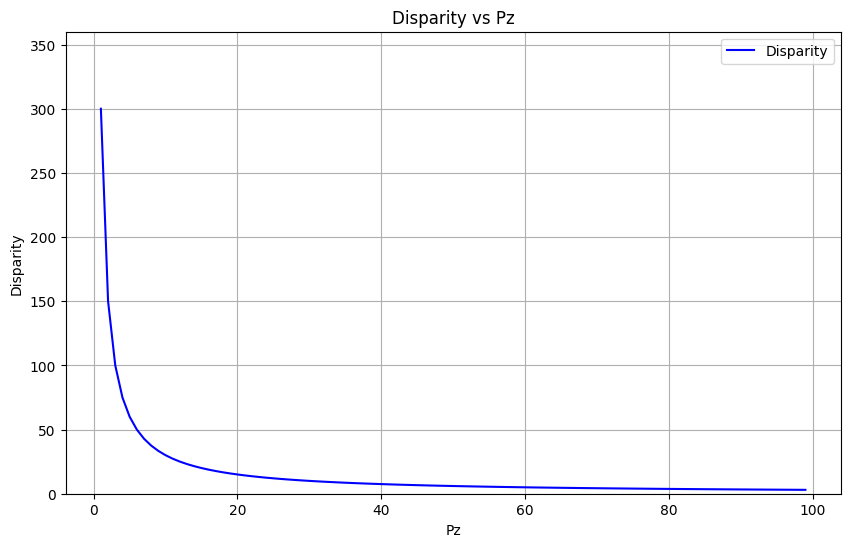

In [3]:
disparity_100 = disparity_in_range_n(100)
x_values = range(100)

plt.figure(figsize=(10, 6)) 
plt.plot(x_values, disparity_100, linestyle='-', color='blue', label='Disparity')

plt.xlabel('Pz')
plt.ylabel('Disparity')
plt.title('Disparity vs Pz')
plt.ylim(0, disparity_100[1] * 1.2)
plt.legend()
plt.grid()

plt.show()

### d) Write a script that calculates the disparity for an image pair.

In [4]:
def ncc(image1, image2, pixels = 5):

    pixels = 5
    print(pixels)

    disp = np.zeros((image1.shape))
    height, width = image1.shape
    

    for i in tqdm(range(pixels, height - pixels)):
        for j in range(pixels, width - pixels):
            
            part1 = image1[i-pixels:i+pixels+1, j-pixels:j+pixels+1]
            mean1 = np.mean(part1)
            

            max_value = -2
            index = 0

            for k in range(max(pixels, j - 35),  min(width - pixels, j + 35)):

                part2 = image2[i-pixels:i+pixels+1, k-pixels:k+pixels+1]
                mean2 = np.mean(part2)

                x = part1 - mean1
                y = part2 - mean2
               
                ncc_value = np.sum(x*y) / ( np.sqrt(np.sum(x**2) * np.sum(y**2)) + 1e-8 )

                if ncc_value > max_value:
                    max_value = ncc_value
                    index = k

            disp[i,j] = abs(j - index)
        
    
    return disp


(206, 300)
(206, 300)
5


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [01:37<00:00,  2.01it/s]


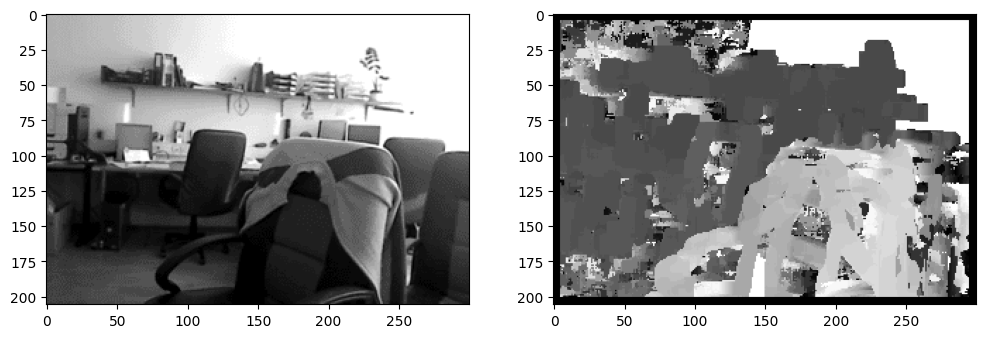

In [5]:
office_left = imread_gray("data/disparity/office_left_resized.png")
office_right = imread_gray("data/disparity/office_right_resized.png")
print(office_left.shape)
print(office_right.shape)

disparity = ncc(office_left, office_right)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(office_left, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(disparity, cmap='gray')

plt.show()

## Exercise 2: Fundamental matrix, epipoles, epipolar lines

### b) Implement a function fundamental_matrix that is given a set of (at least) eight pairs of points from two images and computes the fundamental matrix using the eight-point algorithm.


In [6]:
def fundamental_matrix(points_1, points_2):

    points_1, T1 = normalize_points(np.array(points_1))
    points_2, T2 = normalize_points(np.array(points_2))

    A = []
    for i in range(len(points_1)):
        u1, v1, _ = points_1[i]
        u2, v2, _ = points_2[i]
        A.append([u1*u2, u1*v2, u1, v1*u2, v1*v2, v1, u2, v2, 1])

    A = np.array(A)

    U, S, V = np.linalg.svd(A)
    V = V.T
    F = V[:, -1]
    F = F.reshape((3, 3))

    U, S, V = np.linalg.svd(F)
    D = np.diag(S)
    D[-1] = 0

    F = np.dot(np.dot(U, D), V)

    F = np.dot(np.dot(T2.T, F.T), T1)

    return F


In [7]:
def load_points(path):
    points_1 = []
    points_2 = []
    data = np.loadtxt(path)

    for i in range(data.shape[0]):
        points_1.append([data[i, 0], data[i, 1]])
        points_2.append([data[i, 2], data[i, 3]])
    
    return points_1, points_2

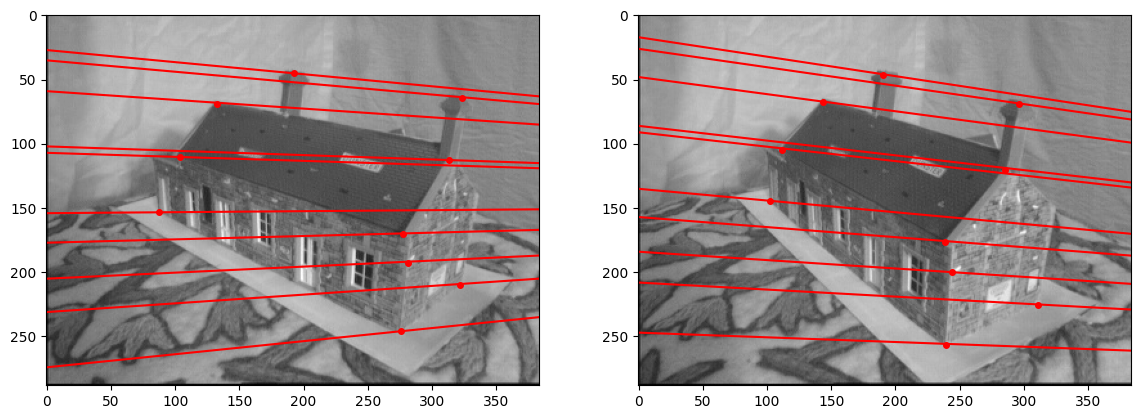

In [8]:
house_1 = imread_gray("data/epipolar/house1.jpg") 
house_2 = imread_gray("data/epipolar/house2.jpg")
height, width = house_1.shape

points_1, points_2 = load_points("data/epipolar/house_points.txt")
F = fundamental_matrix(points_1, points_2)


plt.figure(figsize=(14,8))

plt.subplot(1,2,1)
plt.imshow(house_1, cmap="gray")
for i in range(len(points_1)):
    plt.plot(points_1[i][0], points_1[i][1], 'ro', markersize=4)

for i in range(len(points_2)):
    x = (points_2[i][0], points_2[i][1], 1)
    line = np.dot(F.T, x)
    draw_epiline(line, height, width)


plt.subplot(1, 2, 2)
plt.imshow(house_2, cmap="gray")
for i in range(0, len(points_2)):
    plt.plot(points_2[i][0], points_2[i][1], 'ro',markersize=4)

for i in range(0, len(points_1)):
    x = (points_1[i][0], points_1[i][1], 1)
    line = np.dot(F, x)
    draw_epiline(line, height, width)
    
plt.show()

### c) Write a function reprojection_error that calculates the reprojection error of a fundamental matrix F given two matching points.

In [9]:
def reprojection_error(point_1, point_2, F):


    point_1_h = [point_1[0], point_1[1], 1]
    point_2_h = [point_2[0], point_2[1], 1]
    
    line1 = np.dot(F, point_1_h)
    line2 = np.dot(F.T, point_2_h)

    a1, b1, c1 = line1
    a2, b2, c2 = line2
    
    dist_1 = abs(a1*point_2[0] + b1*point_2[1] + c1) / np.sqrt(a1**2 + b1**2)
    dist_2 = abs(a2*point_1[0] + b2*point_1[1] + c2) / np.sqrt(a2**2 + b2**2)

    error = (dist_1 + dist_2) / 2

    return error


In [10]:
point_1 = [85, 233]
point_2 = [67, 219]

error_1 = reprojection_error(point_1, point_2, F)
print("Reprojection error: ", error_1)

error2 = 0
for i in range(len(points_1)):
    error2 += reprojection_error(points_1[i], points_2[i], F)

error2 = error2 / len(points_1)
print("Symmetric reprojection error: ", error2)

Reprojection error:  0.14674365570484418
Symmetric reprojection error:  0.3309133698054167


### d) Perform fully automatic fundamental matrix estimation on a pair of images from the directory desk.

In [11]:
def ransac_fundamental(matches, points_1, points_2, iterations=1000, threshold=1.0):

    best_F = None
    best_inliers = []
    best_error = float('inf')  
    inlier_counts = []  

    for _ in tqdm(range(iterations)):

        random_matches = random.sample(matches, 8)
        sample_points_1 = []
        sample_points_2 = []
        for a, b in random_matches:
            sample_points_1.append(points_1[a])
            sample_points_2.append(points_2[b])

        F = fundamental_matrix(sample_points_1, sample_points_2)

        error = 0
        inliers = []

        for a, b in matches:
            p1 = points_1[a]
            p2 = points_2[b]

            dist = reprojection_error(p1, p2, F)

            if dist < threshold:
                inliers.append((a, b))  
                error += dist 

        error /= len(matches)

        if len(inliers) > len(best_inliers) or (len(inliers) == len(best_inliers) and error < best_error):
            best_error = error
            best_inliers = inliers
            best_F = F

        inlier_counts.append(len(inliers))


    return best_inliers, best_F


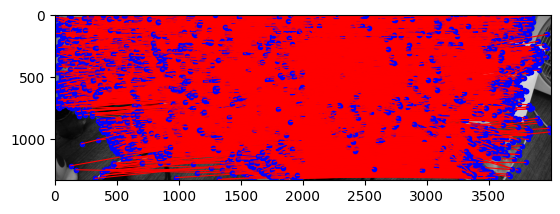

In [12]:
desk_1 = cv2.imread("data/desk/DSC02638.jpg", cv2.IMREAD_GRAYSCALE)
desk_2 = cv2.imread("data/desk/DSC02639.jpg", cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(desk_1, None)
keypoints2, descriptors2 = sift.detectAndCompute(desk_2, None)

points_a = np.array([kp.pt for kp in keypoints1])  
points_b = np.array([kp.pt for kp in keypoints2])  

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

matches = sorted(matches, key = lambda x:x.distance)

s1 = np.array([keypoints1[m.queryIdx].pt for m in matches]) 
s2 = np.array([keypoints2[m.trainIdx].pt for m in matches]) 
indexes = [(m.queryIdx, m.trainIdx) for m in matches]  

display_matches(desk_1, s1, desk_2, s2)


In [13]:
best_inliers, best_F = ransac_fundamental(indexes, points_a, points_b)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.17it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1612.53it/s]


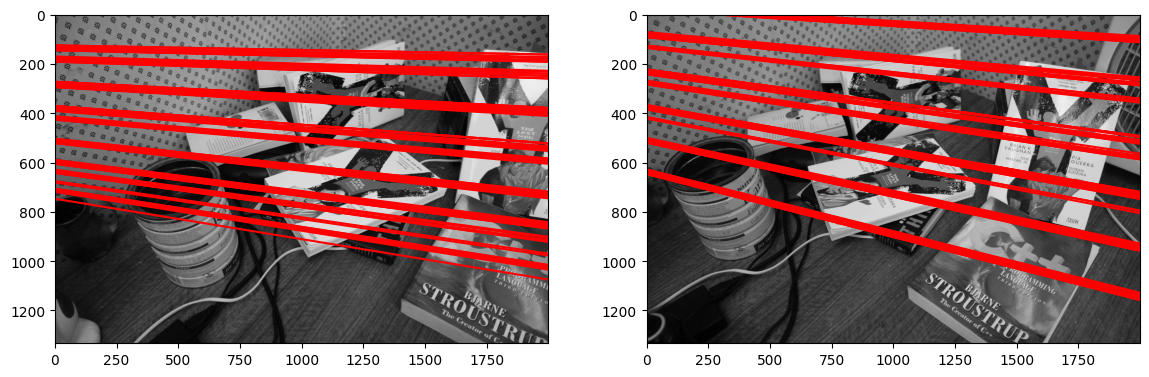

In [14]:
plt.figure(figsize=(14,8))
height, width = desk_1.shape

plt.subplot(1,2,1)
plt.imshow(desk_1, cmap="gray")

for i in tqdm(range(0, 100)):
    x = (points_b[i][0], points_b[i][1], 1)
    line = np.dot(best_F.T, x)
    draw_epiline(line, height, width)


plt.subplot(1, 2, 2)
plt.imshow(desk_2, cmap="gray")

for i in tqdm(range(0, 100)):
    x = (points_a[i][0], points_a[i][1], 1)
    line = np.dot(best_F, x)
    draw_epiline(line, height, width)
    
plt.show()

## Exercise 3: Triangulation

### a) Implement the function triangulate that accepts a set of correspondence points and a pair of calibration matrices as an input and returns the triangulated 3D points. 

In [15]:
def triangulate(P1, P2, point_1, point_2):

    A = np.zeros((4, 4))

    x1 = np.array([[0, -1, point_1[1]], [1, 0, -point_1[0]], [-point_1[1], point_1[0], 0]])
    x2 = np.array([[0, -1, point_2[1]], [1, 0, -point_2[0]], [-point_2[1], point_2[0], 0]])

    A[0:2, :] = np.dot(x1, P1)[0:2, :]
    A[2:4, :] = np.dot(x2, P2)[0:2, :]

    U, S, V = np.linalg.svd(A)

    V=V.T
    
    X = V[:, 3] / V[3, 3]
    
    return X[:3] 


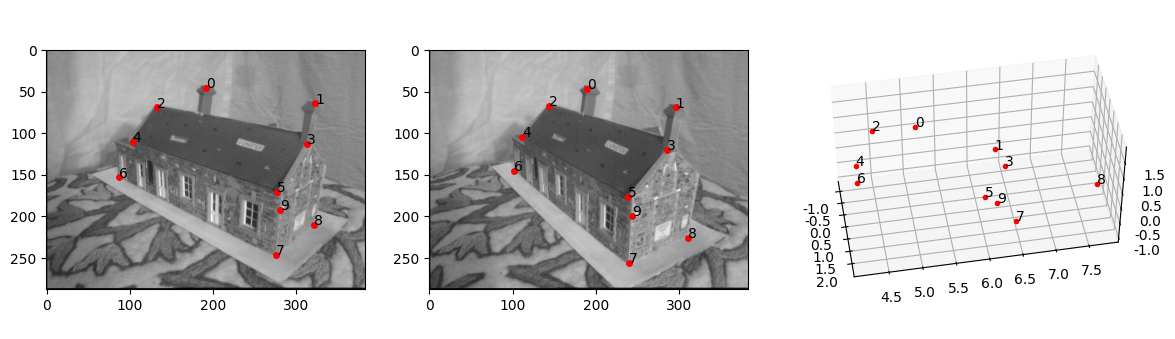

In [16]:
points_1, points_2 = load_points("data/epipolar/house_points.txt")

P1 = np.loadtxt("data/epipolar/house1_camera.txt")
P2 = np.loadtxt("data/epipolar/house2_camera.txt")

results = []
for i in range(len(points_1)):
    results.append(triangulate(P1, P2, points_1[i], points_2[i]))

T = np.array([[-1, 0, 0], [0, 0, 1], [0, -1, 0]])
results = np.dot(results, T)

house_1 = imread_gray("data/epipolar/house1.jpg") 
house_2 = imread_gray("data/epipolar/house2.jpg")

plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.imshow(house_1, cmap="gray")
for i in range(len(points_1)):
    plt.plot(points_1[i][0], points_1[i][1], 'ro', markersize=4)
    plt.text(points_1[i][0], points_1[i][1], str(i))

plt.subplot(1,3,2)
plt.imshow(house_2, cmap="gray")
for i in range(len(points_2)):
    plt.plot(points_2[i][0], points_2[i][1], 'ro', markersize=4)
    plt.text(points_2[i][0], points_2[i][1], str(i))

ax = plt.subplot(1,3,3, projection='3d')
for i, point in enumerate(results):
    plt.plot(point[0], point[1], point[2], 'r.')
    ax.text(point[0], point[1], point[2], str(i))

ax.set_box_aspect([1, 2, 1])

ax.set_xticks([-1, -0.5, 0, 0.5, 1, 1.5, 2])
ax.set_xticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0', '1.5', '2.0'])

ax.set_yticks([4.5, 5, 5.5, 6, 6.5, 7, 7.5])
ax.set_yticklabels(['4.5', '5.0', '5.5', '6.0', '6.5', '7.0', '7.5'])

ax.set_zticks([-1, -0.5, 0, 0.5, 1, 1.5])
ax.set_zticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0', '1.5'])

ax.view_init(elev=45, azim=-10)

plt.show()